# Extracting Rules with XAI from RAPP predictions

## Dropout when no exams in last three semesters

In [1]:
import pandas as pd
import numpy as np

from rapp import data

In [2]:
data.connect("data/rapp.db")

In [3]:
sql = "sql/cs_first_term_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,StdevNoteQuadriert,Dropout
0,1976,männlich,1,21,5,4,44.0,1.712500,0.172969,0
1,1984,männlich,1,20,5,5,30.0,3.675000,0.049500,1
2,1981,männlich,1,23,1,1,10.0,2.700000,0.000000,1
3,1985,männlich,1,20,14,14,140.0,1.962500,0.404196,1
4,1983,männlich,1,22,7,7,70.0,2.766667,0.703810,0
...,...,...,...,...,...,...,...,...,...,...
1003,1988,weiblich,1,31,6,6,43.0,1.333333,0.082222,1
1004,1994,männlich,1,25,1,1,5.0,3.300000,0.000000,1
1005,1994,männlich,1,25,1,0,0.0,5.000000,0.000000,1
1006,1986,weiblich,1,33,1,0,0.0,5.000000,0.000000,1


In [4]:
def print_metric(cols, df):
    rows = len(df)
    for col in cols:
        count = len(df[df[col]==1])
        print(f"{col}:", count, f"({count*100./rows} %)")

In [5]:
print_metric(["Dropout"], df)

Dropout: 756 (75.0 %)


In [6]:
df_classification = df.copy(deep=True)
df_classification["StdevNote"] = np.sqrt(df["StdevNoteQuadriert"])
df_classification = df_classification.drop(["StdevNoteQuadriert"], axis=1)

In [7]:
df_classification.head()

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote
0,1976,männlich,1,21,5,4,44.0,1.712500,0,0.415895
1,1984,männlich,1,20,5,5,30.0,3.675000,1,0.222486
2,1981,männlich,1,23,1,1,10.0,2.700000,1,0.000000
3,1985,männlich,1,20,14,14,140.0,1.962500,1,0.635764
4,1983,männlich,1,22,7,7,70.0,2.766667,0,0.838934


We need to one-hot encode the gender.

In [8]:
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)

In [9]:
df_classification.head()

,Deutsch,AlterEinschreibung,KlausurenGeschrieben,KlausurenBestanden,Ects,DurchschnittsNote,Dropout,StdevNote,Männlich,Weiblich,Divers
0,1,21,5,4,44.0,1.712500,0,0.415895,1,0,0
1,1,20,5,5,30.0,3.675000,1,0.222486,1,0,0
2,1,23,1,1,10.0,2.700000,1,0.000000,1,0,0
3,1,20,14,14,140.0,1.962500,1,0.635764,1,0,0
4,1,22,7,7,70.0,2.766667,0,0.838934,1,0,0


### Prepare train and test set

In [10]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

### Train classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [13]:
clf = DecisionTreeClassifier(class_weight="balanced", min_impurity_decrease=0.001)

In [14]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', min_impurity_decrease=0.001)

In [15]:
def eval_model(clf):
    y_pred = clf.predict(X_train)
    bacc = balanced_accuracy_score(y_train, y_pred)
    area = roc_auc_score(y_train, y_pred)
    conf = confusion_matrix(y_train, y_pred)
    print("# Trainset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)

    y_pred = clf.predict(X_test)
    bacc = balanced_accuracy_score(y_test, y_pred)
    area = roc_auc_score(y_test, y_pred)
    conf = confusion_matrix(y_test, y_pred)
    print("# Testset")
    print(f"Balanced accuracy: {bacc}")
    print(f"Area under curve: {area}")
    print(f"Confusion Matrix (tn, fp, fn, tp):")
    print(conf)


In [16]:
eval_model(clf)

# Trainset
Balanced accuracy: 0.8595588583329389
Area under curve: 0.8595588583329389
Confusion Matrix (tn, fp, fn, tp):
[[169  16]
 [111 460]]
# Testset
Balanced accuracy: 0.6762404195240016
Area under curve: 0.6762404195240016
Confusion Matrix (tn, fp, fn, tp):
[[ 41  26]
 [ 48 137]]


### Display rules learned

In [17]:
%matplotlib inline
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [60, 20]

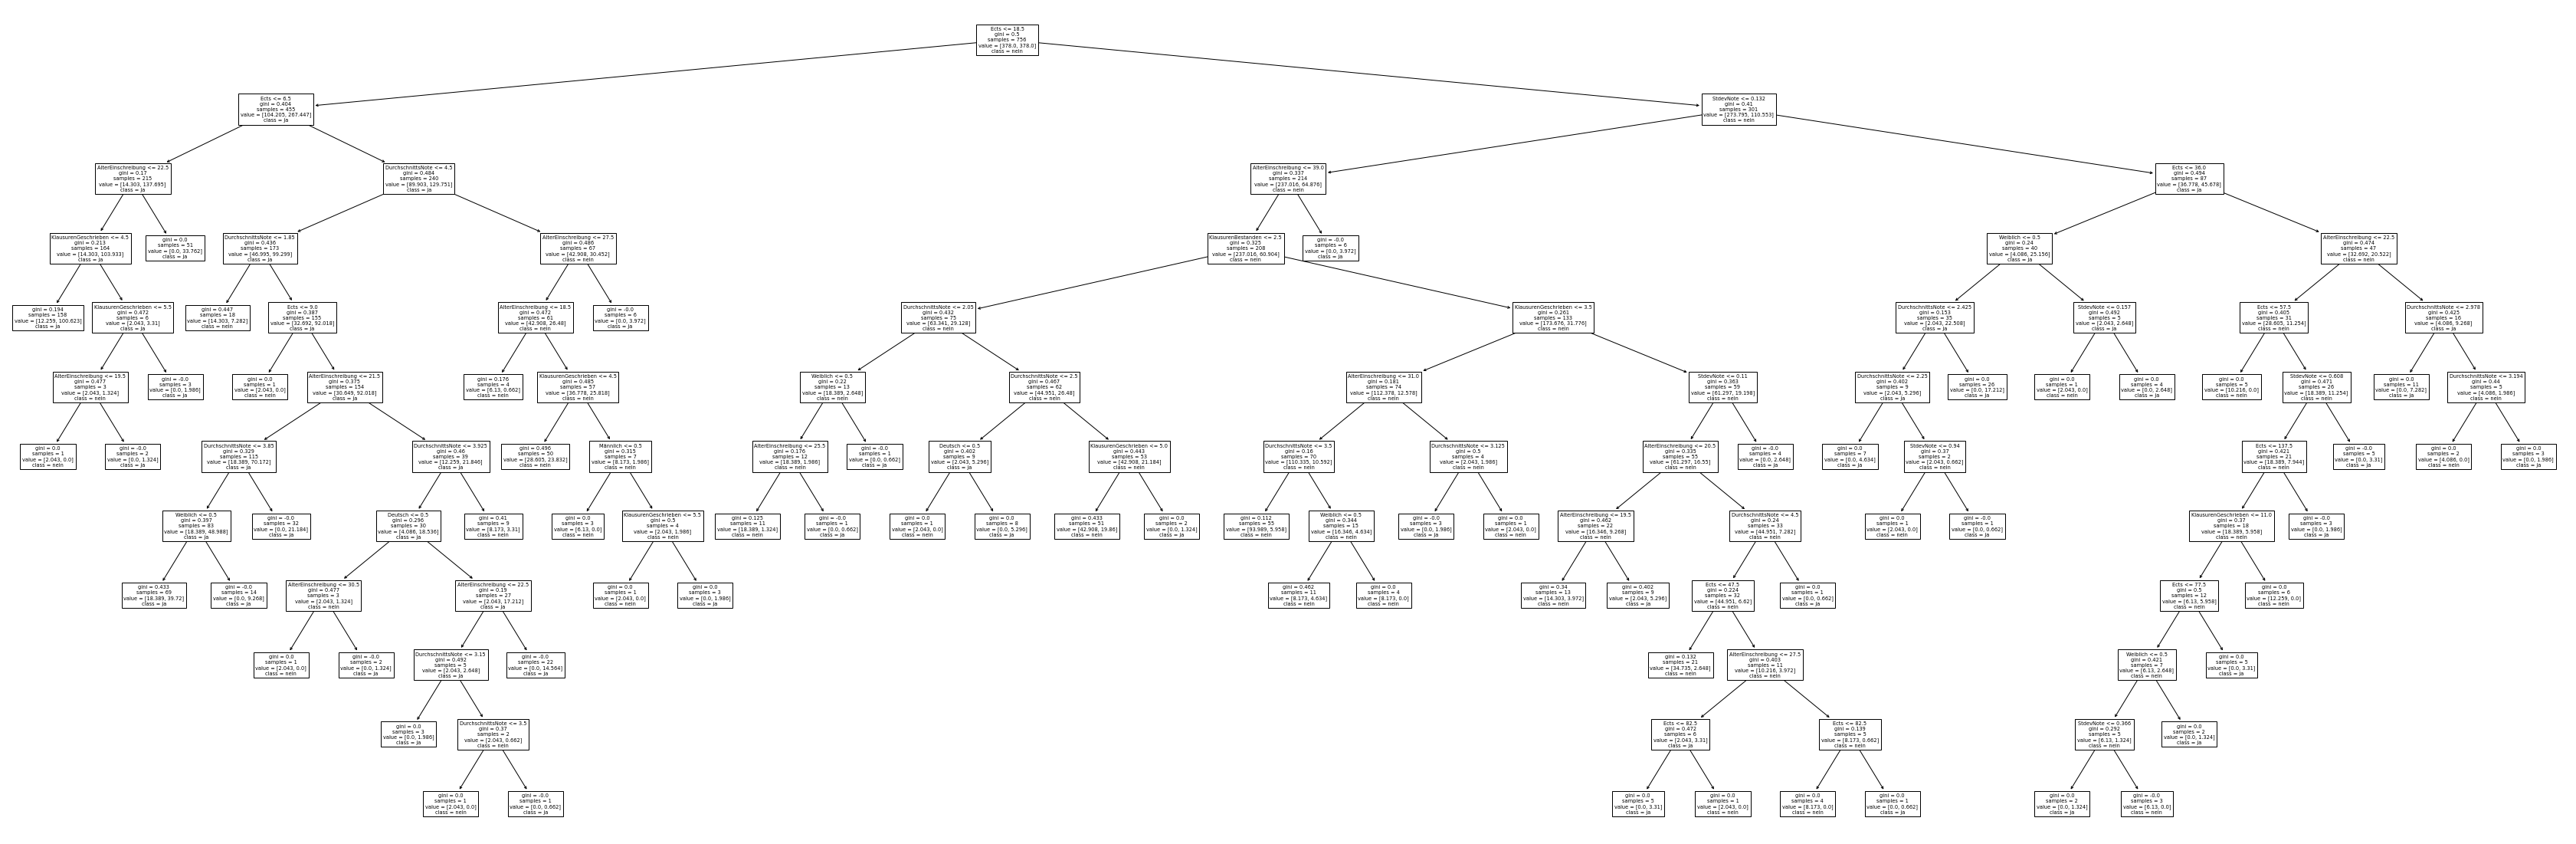

In [18]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

(Right click image -> open in new tab to get a zoomable version.)

### Post pruning of the decision tree

As the decision tree above grew notably large and complex, we want to prune it to achieve a smaller yet comparably performant model. This will also battle the overfitting we observe (higher performances on training than test set).

This cost complexity pruning approach follows the example from https://ranvir.xyz/blog/practical-approach-to-tree-pruning-using-sklearn/ closely.

In [19]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00132275, 0.00132275, 0.0013418 , 0.00142805,
        0.00146051, 0.00160299, 0.00162009, 0.00172835, 0.00178071,
        0.0018164 , 0.00183628, 0.00201307, 0.0021124 , 0.00211769,
        0.00217225, 0.00217944, 0.00244598, 0.00288577, 0.00304733,
        0.00310093, 0.00317604, 0.0033306 , 0.00334151, 0.00334523,
        0.00339236, 0.00353565, 0.00380059, 0.00396703, 0.00433705,
        0.00448446, 0.00656327, 0.00780738, 0.00898583, 0.01124568,
        0.01969835, 0.02361052, 0.09327566]),
 'impurities': array([0.19759759, 0.19892035, 0.2002431 , 0.20561031, 0.20846642,
        0.21138743, 0.21299042, 0.21461051, 0.21633886, 0.21811957,
        0.22175237, 0.22909748, 0.23312362, 0.24157324, 0.24369093,
        0.24803543, 0.25239431, 0.25728628, 0.26305782, 0.27219982,
        0.27530075, 0.27847679, 0.28513798, 0.29182099, 0.29851145,
        0.30868854, 0.31222419, 0.31602478, 0.31999181, 0.32432886,
        0.32881331, 0.33537658, 0.34318396

Text(0, 0.5, 'total impurity of leaves')

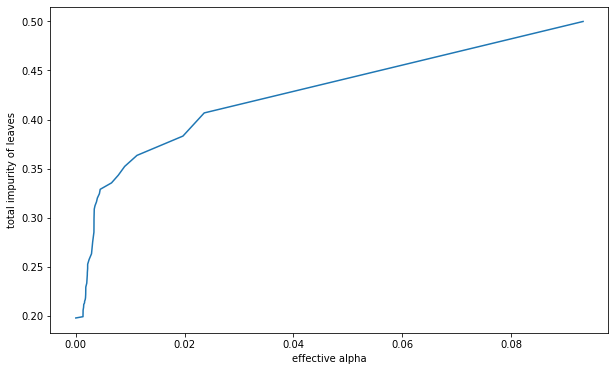

In [20]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, impurities)
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")

In [21]:
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

Text(0, 0.5, 'total depth')

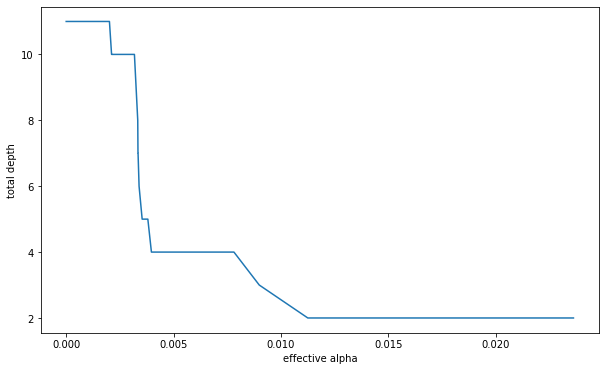

In [22]:
tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


Text(0, 0.5, 'Balanced Accuracy scores')

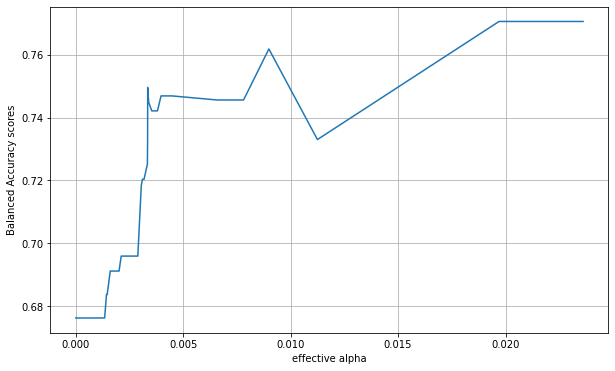

In [23]:
acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

In [24]:
selected_ccp = 0.009

In [25]:
clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)

# Trainset
Balanced accuracy: 0.7437970369669145
Area under curve: 0.7437970369669143
Confusion Matrix (tn, fp, fn, tp):
[[132  53]
 [129 442]]
# Testset
Balanced accuracy: 0.7805970149253731
Area under curve: 0.7805970149253731
Confusion Matrix (tn, fp, fn, tp):
[[ 51  16]
 [ 37 148]]


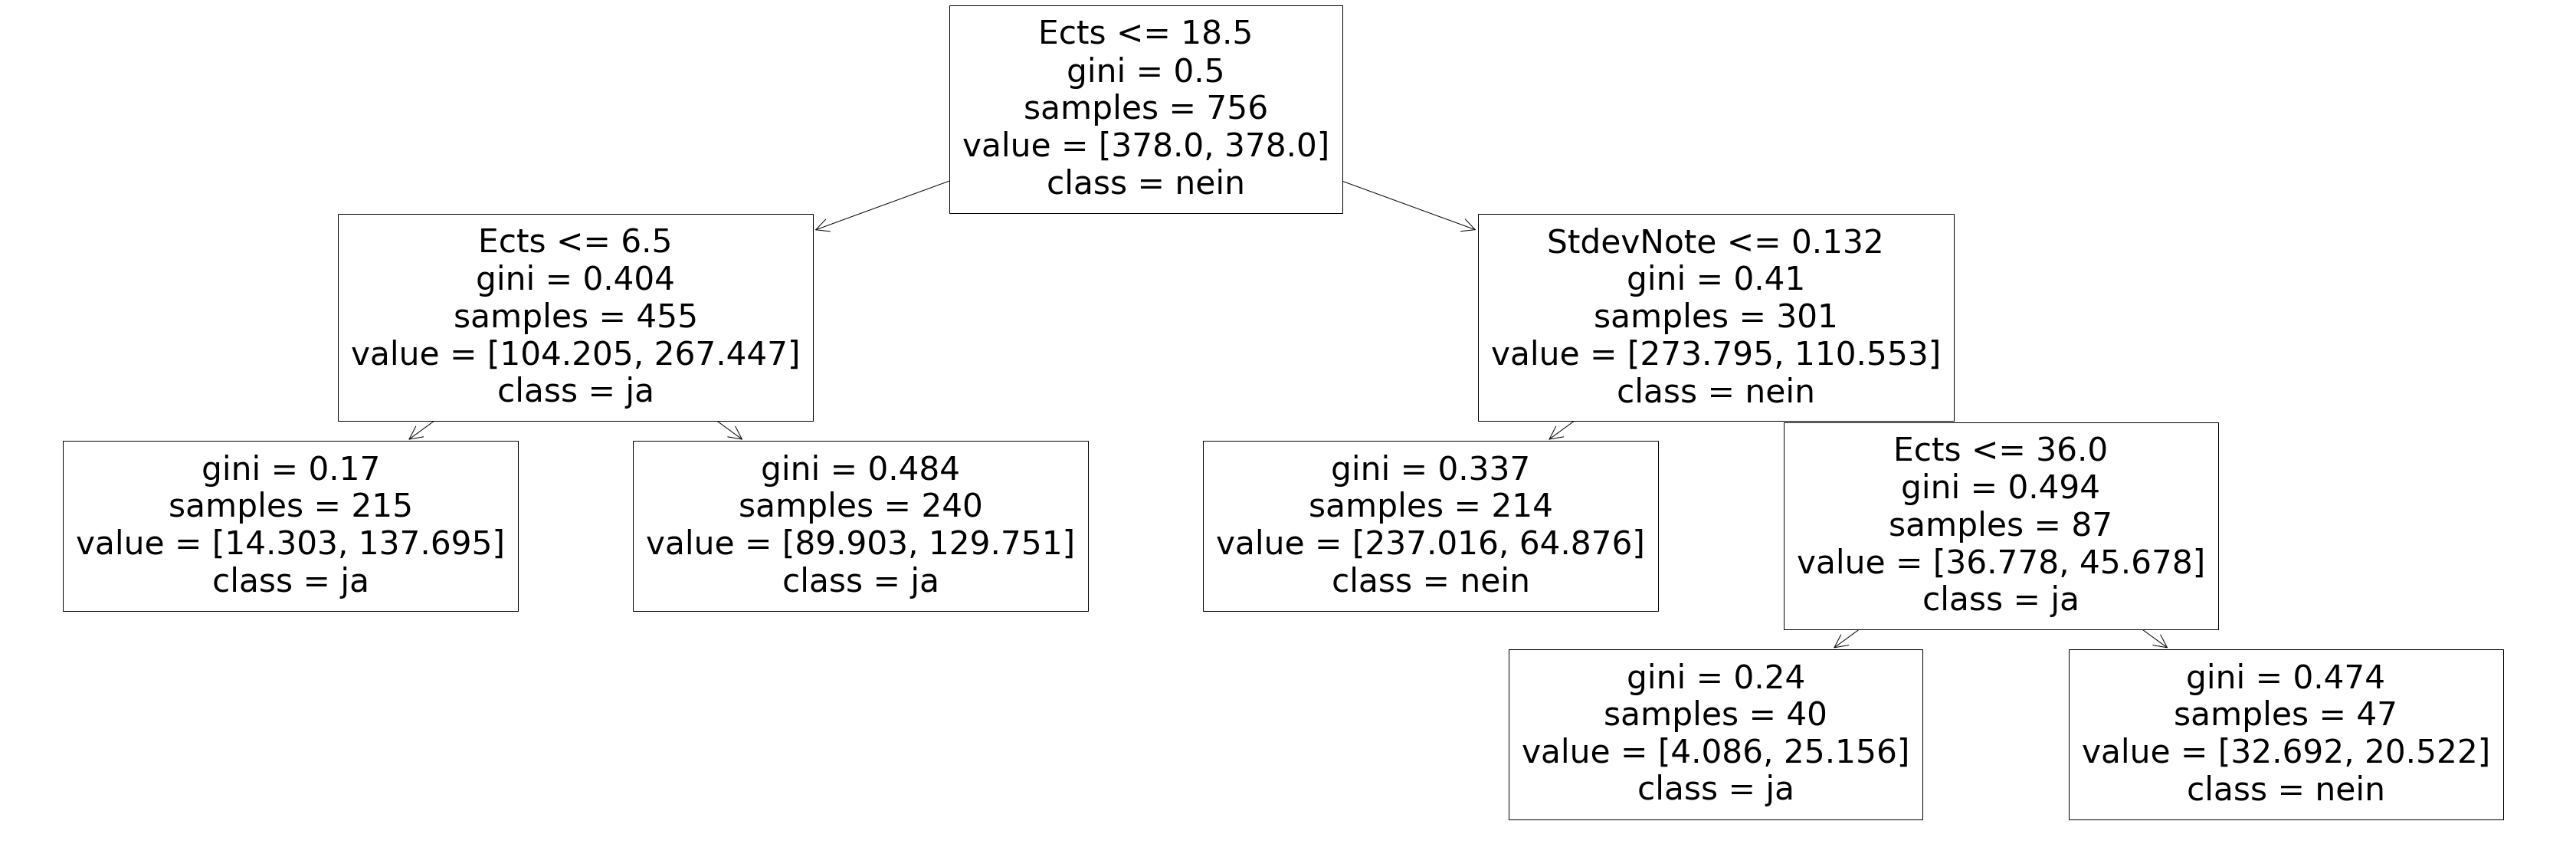

In [26]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

## Alternative Data: Specific modules

The above approach only accounted for ECTS in first semester. As we can see there are some weird edge cases going on:

* Students with more than 36 ECTS
* Focus on standard deviation of the grade

In the following, we will look at some slightly altered version in which we do not investigate the accumulated ECTS as much as the individual modules a computing student would take in their first semester:

* software development and programming
* calculus I
* algorithms and data structures

In [27]:
sql = "sql/cs_first_three_module_dropout.sql"
df = data.query_sql_file(sql, data.db_conn)

df

,Geburtsjahr,Geschlecht,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout
0,1972,männlich,1,35,1,1,0,0,5.0,0,0,5.0,0
1,1987,weiblich,1,20,1,1,1,1,3.7,1,1,3.0,0
2,1988,männlich,1,19,1,2,1,1,3.3,0,0,5.0,0
3,1989,weiblich,1,18,1,1,0,0,5.0,1,1,1.0,1
4,1987,weiblich,0,20,1,1,1,1,4.0,1,1,1.3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
874,1995,männlich,1,23,0,0,0,1,5.0,0,0,5.0,1
875,1990,männlich,1,28,0,0,0,1,5.0,0,0,5.0,1
876,1989,männlich,1,30,0,0,1,1,1.7,0,0,5.0,1
877,1993,männlich,1,26,1,1,0,0,5.0,0,0,5.0,1


In [28]:
print_metric(["Dropout", "LABestanden", "ProgBestanden", "AlgoBestanden"], df)

Dropout: 650 (73.94766780432309 %)
LABestanden: 340 (38.68031854379977 %)
ProgBestanden: 497 (56.5415244596132 %)
AlgoBestanden: 99 (11.262798634812286 %)


In [29]:
# Preprocess data
df_classification = df.copy(deep=True)
df_classification["Männlich"] = 1*(df_classification["Geschlecht"] == "männlich")
df_classification["Weiblich"] = 1*(df_classification["Geschlecht"] == "weiblich")
df_classification["Divers"] = 1*(df_classification["Geschlecht"] == "divers")

df_classification = df_classification.drop(["Geschlecht", "Geburtsjahr"], axis=1)
df_classification.head()

,Deutsch,AlterEinschreibung,LABestanden,LAVersuche,ProgBestanden,ProgVersuche,ProgNote,AlgoBestanden,AlgoVersuche,AlgoNote,Dropout,Männlich,Weiblich,Divers
0,1,35,1,1,0,0,5.0,0,0,5.0,0,1,0,0
1,1,20,1,1,1,1,3.7,1,1,3.0,0,0,1,0
2,1,19,1,2,1,1,3.3,0,0,5.0,0,1,0,0
3,1,18,1,1,0,0,5.0,1,1,1.0,1,0,1,0
4,0,20,1,1,1,1,4.0,1,1,1.3,1,0,1,0


In [30]:
X = df_classification.drop(["Dropout"], axis=1)
y = df_classification["Dropout"]

feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)


clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
eval_model(clf)

# Trainset
Balanced accuracy: 0.8452089924264212
Area under curve: 0.8452089924264212
Confusion Matrix (tn, fp, fn, tp):
[[151  20]
 [ 94 394]]
# Testset
Balanced accuracy: 0.7336100468284377
Area under curve: 0.7336100468284377
Confusion Matrix (tn, fp, fn, tp):
[[ 45  13]
 [ 50 112]]


The data with the explicit grades already leads to more accurate results as we can see.

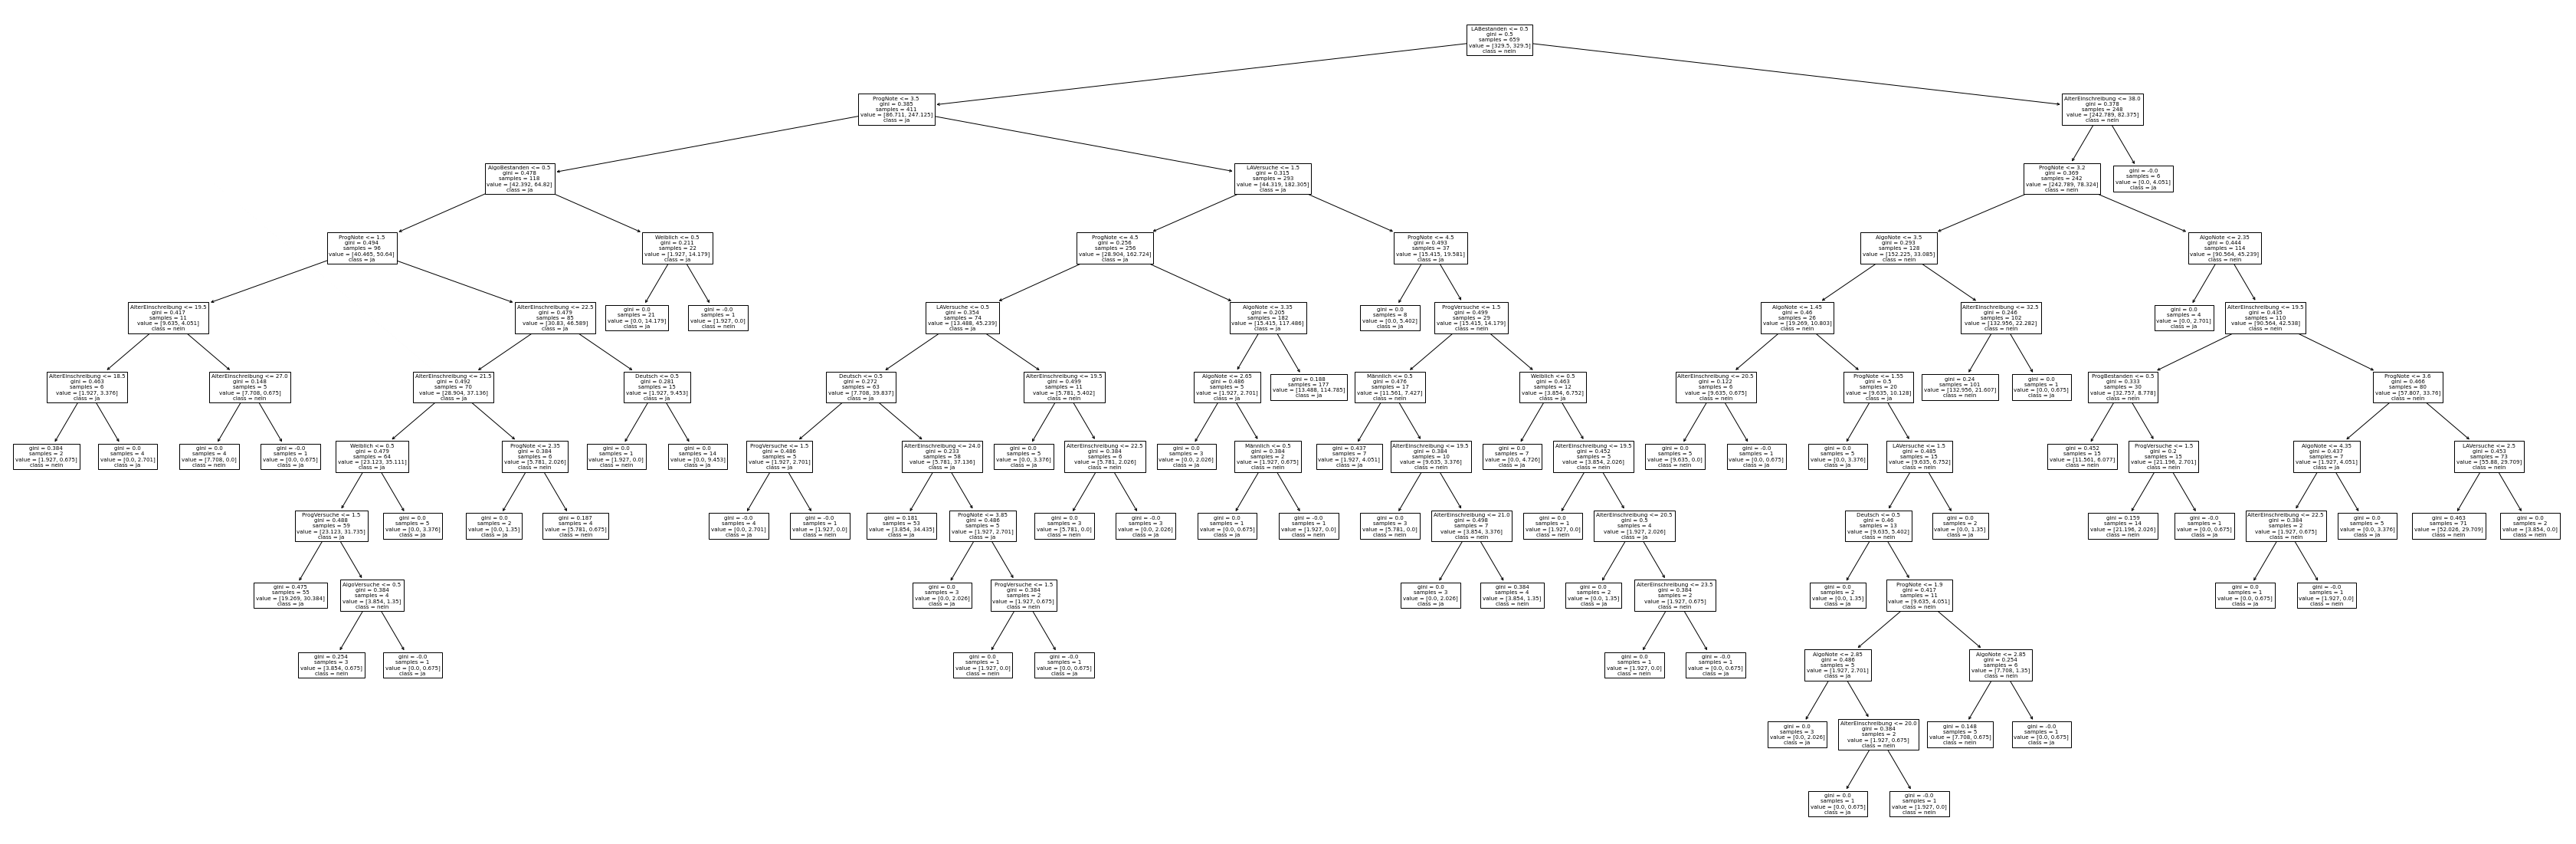

In [31]:
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

### Post pruning

In [32]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
path

{'ccp_alphas': array([0.        , 0.00129122, 0.00134318, 0.00147565, 0.00150971,
        0.00151745, 0.00151745, 0.00151745, 0.00151745, 0.00157231,
        0.00160323, 0.00160428, 0.00165483, 0.00174532, 0.00176085,
        0.00188413, 0.00191498, 0.00214868, 0.00220556, 0.00220946,
        0.00224212, 0.00233056, 0.00259084, 0.00293682, 0.00304838,
        0.0033829 , 0.00342625, 0.00371929, 0.00376129, 0.00383299,
        0.00476136, 0.00568342, 0.00694112, 0.00753475, 0.00882141,
        0.11852814]),
 'impurities': array([0.22841156, 0.22970278, 0.23373233, 0.23520798, 0.23671769,
        0.23823514, 0.23975259, 0.24127004, 0.24278749, 0.24593211,
        0.24753535, 0.25074391, 0.25405357, 0.25754421, 0.26458759,
        0.26647172, 0.26838669, 0.27483273, 0.27703829, 0.2814572 ,
        0.28818355, 0.29284468, 0.29802635, 0.30096317, 0.30401155,
        0.31754314, 0.32782188, 0.33154116, 0.33530246, 0.34296844,
        0.35249116, 0.35817458, 0.3651157 , 0.37265046, 0.38147186

Text(0, 0.5, 'Balanced Accuracy scores')

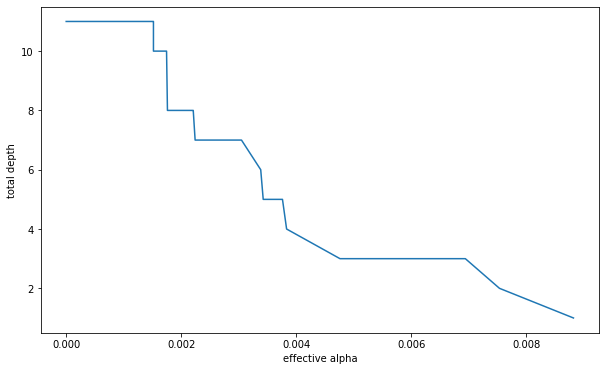

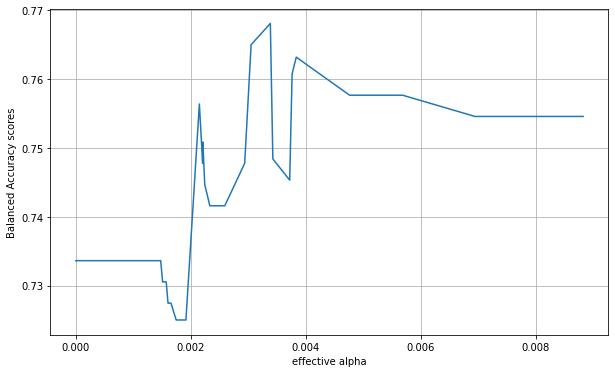

In [33]:
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha,
                                 class_weight="balanced", min_impurity_decrease=0.001)
    clf.fit(X_train, y_train)
    clfs.append(clf)

tree_depths = [clf.tree_.max_depth for clf in clfs]
plt.figure(figsize=(10,  6))
plt.plot(ccp_alphas[:-1], tree_depths[:-1])
plt.xlabel("effective alpha")
plt.ylabel("total depth")


acc_scores = [balanced_accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

plt.figure(figsize=(10,  6))
plt.grid()
plt.plot(ccp_alphas[:-1], acc_scores[:-1])
plt.xlabel("effective alpha")
plt.ylabel("Balanced Accuracy scores")

# Trainset
Balanced accuracy: 0.7524925702233727
Area under curve: 0.7524925702233727
Confusion Matrix (tn, fp, fn, tp):
[[127  44]
 [116 372]]
# Testset
Balanced accuracy: 0.7631971051511282
Area under curve: 0.7631971051511282
Confusion Matrix (tn, fp, fn, tp):
[[ 47  11]
 [ 46 116]]


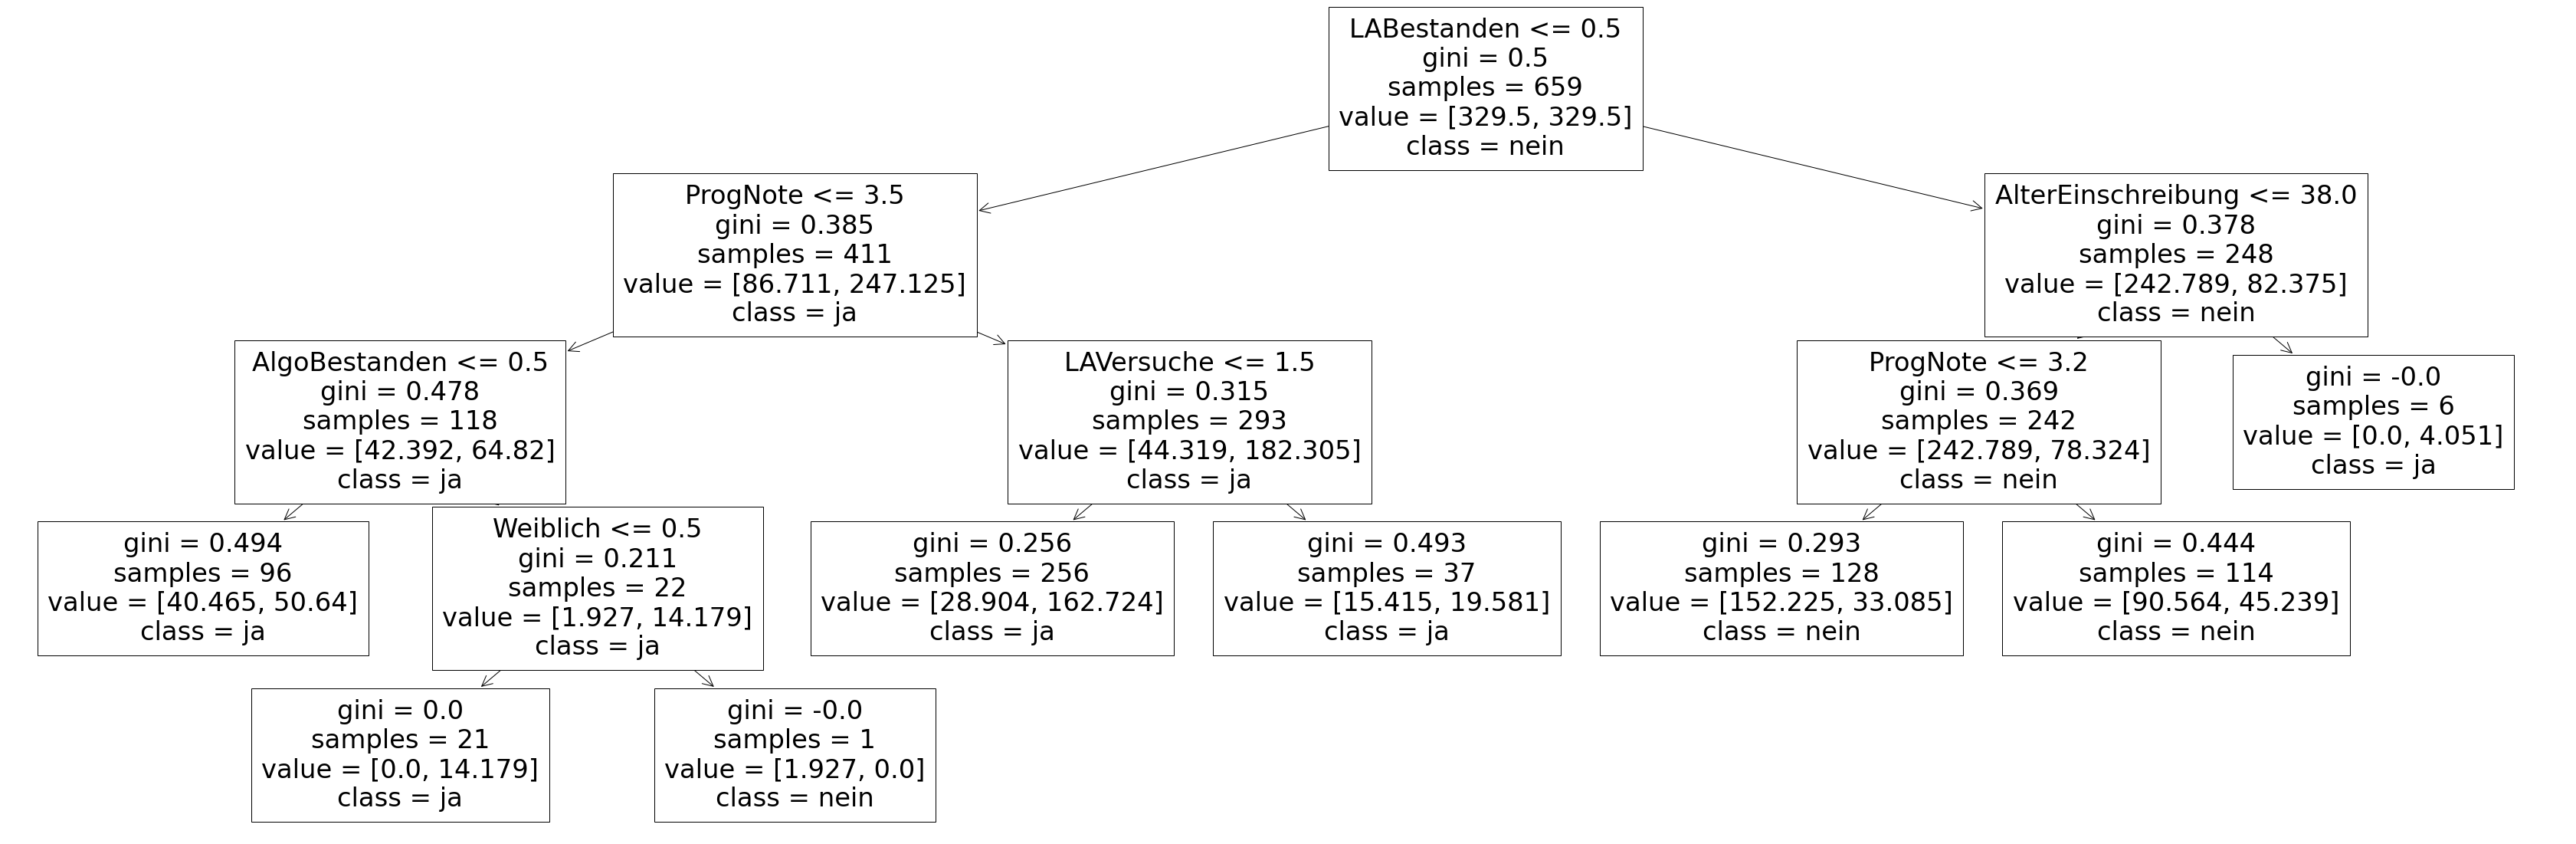

In [34]:
selected_ccp = 0.004
# selected_ccp = 0.0035

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()

# Trainset
Balanced accuracy: 0.743421052631579
Area under curve: 0.7434210526315791
Confusion Matrix (tn, fp, fn, tp):
[[126  45]
 [122 366]]
# Testset
Balanced accuracy: 0.7545764154959558
Area under curve: 0.7545764154959558
Confusion Matrix (tn, fp, fn, tp):
[[ 46  12]
 [ 46 116]]


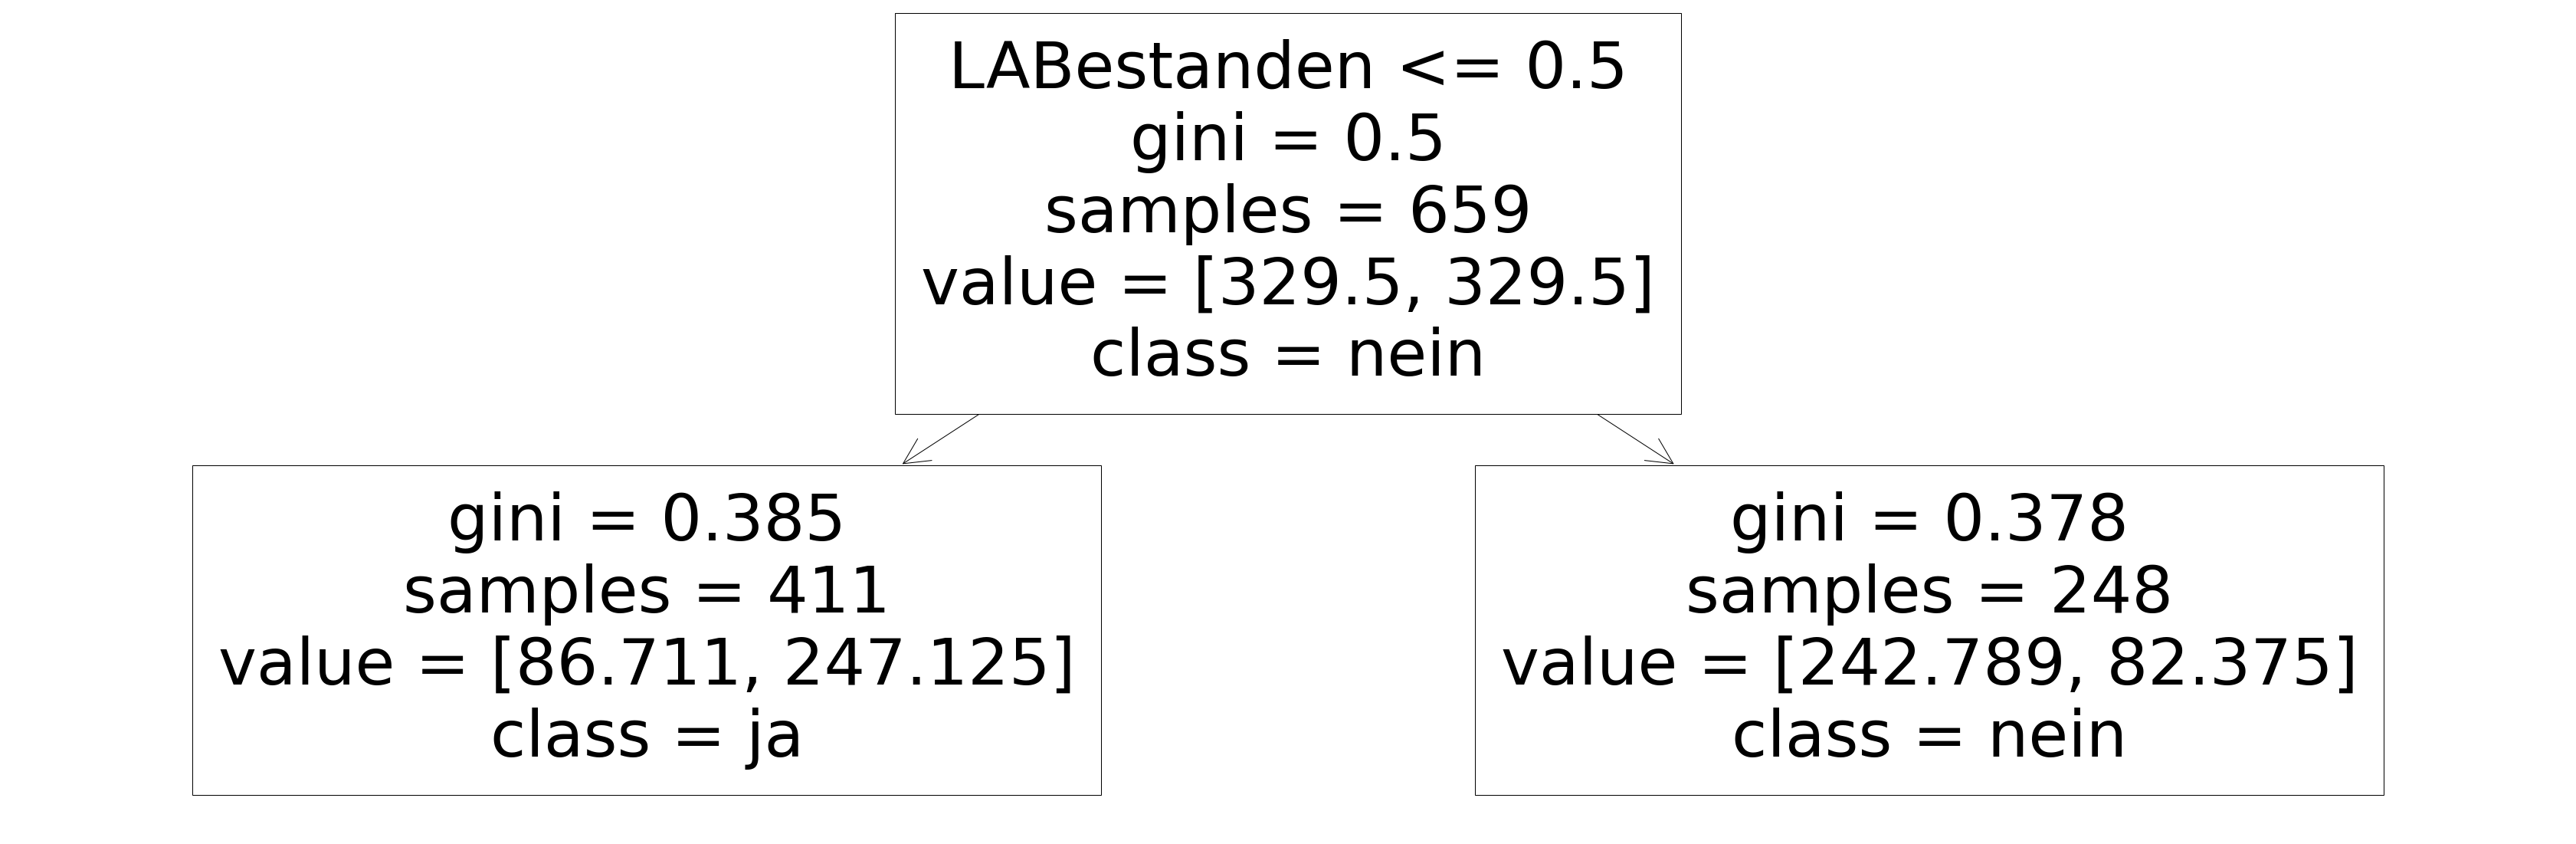

In [35]:
selected_ccp = 0.01

clf = DecisionTreeClassifier(random_state=0, class_weight="balanced", min_impurity_decrease=0.001,
                             ccp_alpha=selected_ccp)
clf.fit(X_train, y_train)

eval_model(clf)
plot_tree(clf, feature_names = feature_names, class_names=["nein", "ja"])
plt.show()


### Dropping Algorithms and Data Structures

As Algorithms and Data Structures is a third semester module for the majority of students in the data base (only changed recently to a first-semester course), we could interpret some correlations regarding the third semester. However, due to our constraint that each performance measure needs to be from the first semester, we circumvent the problem. As we see above, AlDat is not part of the resulting tree.